In [0]:
import os, time, gc, datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

import lightgbm as lgb

pd.set_option('max_rows', 9999)
pd.set_option('max_columns', 9999)

start = time.time()

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
cd /content/gdrive/My Drive/ML 4

/content/gdrive/My Drive/ML 4


In [0]:
train = pd.read_csv("transaction_id_combined.csv")

In [0]:
cd /content/gdrive/My Drive/ML 4/Test

/content/gdrive/My Drive/ML 4/Test


In [0]:
ls

 cdmb_hyunji_Version_underlgbm_0_89.ipynb  'test_combined(Yaehee_version).csv'
 sample_submission.csv                      Test_Please.csv
 submission.csv                             test_region.csv
 test_combined.csv                         'train_combined(Yaehee_version).csv'


In [0]:
test = pd.read_csv("Test_Please.csv")

In [0]:
not_fraud = train[train.isFraud==0]
fraud = train[train.isFraud==1]

In [0]:
from sklearn.utils import resample

not_fraud_downsampled = resample(not_fraud,

                               n_samples = len(fraud), # match minority n
                                random_state = 27) # reproducible results

In [0]:
downsampled = pd.concat([not_fraud_downsampled, fraud])


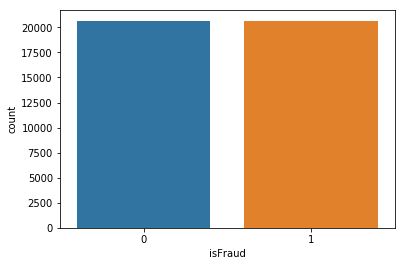

In [0]:
sns.countplot(x='isFraud', data=downsampled)
plt.show()


In [0]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score


import xgboost as xgb
import matplotlib.pyplot as plt

In [0]:
# make Dataset
features = [c for c in downsampled.columns if c not in ['TransactionID', 'isFraud']]
target = 'isFraud'

X = downsampled[features].values
Y = downsampled[target].values

X_test = test[features].values

oof = np.zeros(len(downsampled))
preds = np.zeros(len(test))
feature_importance = np.zeros(len(features))

In [0]:
# Config
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
params = {
    'task': 'train',
    'objective': 'binary',
    'metrics': 'auc',
    'max_depth': 9,
    'learning_rate': 0.15,
    'random_state': 0,
    'bagging_fraction': 0.9,
    'feature_fraction': 0.9,
}
config = {
    'num_boost_round':  500,
    'early_stopping_rounds': 100,
    'verbose_eval': 2000
}

In [0]:
# %%time
# Model training
for i, (trn_index, val_index) in enumerate(cv.split(X, Y)):
    print('{} Folds'.format(i + 1))
    
    _start = time.time()
    X_train, Y_train = X[trn_index], Y[trn_index]
    X_valid, Y_valid = X[val_index], Y[val_index]
    
    trn_data = lgb.Dataset(X_train, label=Y_train)
    val_data = lgb.Dataset(X_valid, label=Y_valid, reference=trn_data)
    
    model = lgb.train(params, trn_data, valid_sets=[val_data, trn_data], valid_names=['eval', 'train'], **config)
    
    oof[val_index] = model.predict(X_valid)
    preds += model.predict(X_test, iteration=model.best_iteration) / cv.get_n_splits()
    feature_importance += model.feature_importance(iteration=model.best_iteration)
    
    elapsedtime = time.time() - _start
    s = datetime.timedelta(seconds=elapsedtime)

    print('{} Folds Running Time: {}'.format(i + 1, str(s)))
    print('#' * 50)
    
    del model
    gc.collect()

1 Folds
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[500]	train's auc: 0.991461	eval's auc: 0.93471
1 Folds Running Time: 0:00:14.252664
##################################################
2 Folds
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[500]	train's auc: 0.991699	eval's auc: 0.928225
2 Folds Running Time: 0:00:14.426440
##################################################
3 Folds
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[500]	train's auc: 0.991013	eval's auc: 0.936493
3 Folds Running Time: 0:00:14.408887
##################################################
4 Folds
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[500]	train's auc: 0.99173	eval's auc: 0.932727
4 Folds Running Time: 0:00:14.526486
#############################

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score

In [0]:
# pred = clf.predict(X_test)
# print('F1:{}'.format(f1_score(y_test, pred)))

print('F1:{}'.format(f1_score(downsampled['isFraud'], oof > 0.5)),
     'ROC_AUC:{}'.format(roc_auc_score(downsampled['isFraud'], oof > 0.5)), sep = '\n')

Accuracy:0.8565067995934763
Precision:0.8725534820209376
Recall:0.8349707206117214
F1:0.8533485013354437
ROC_AUC:0.8565067995934763


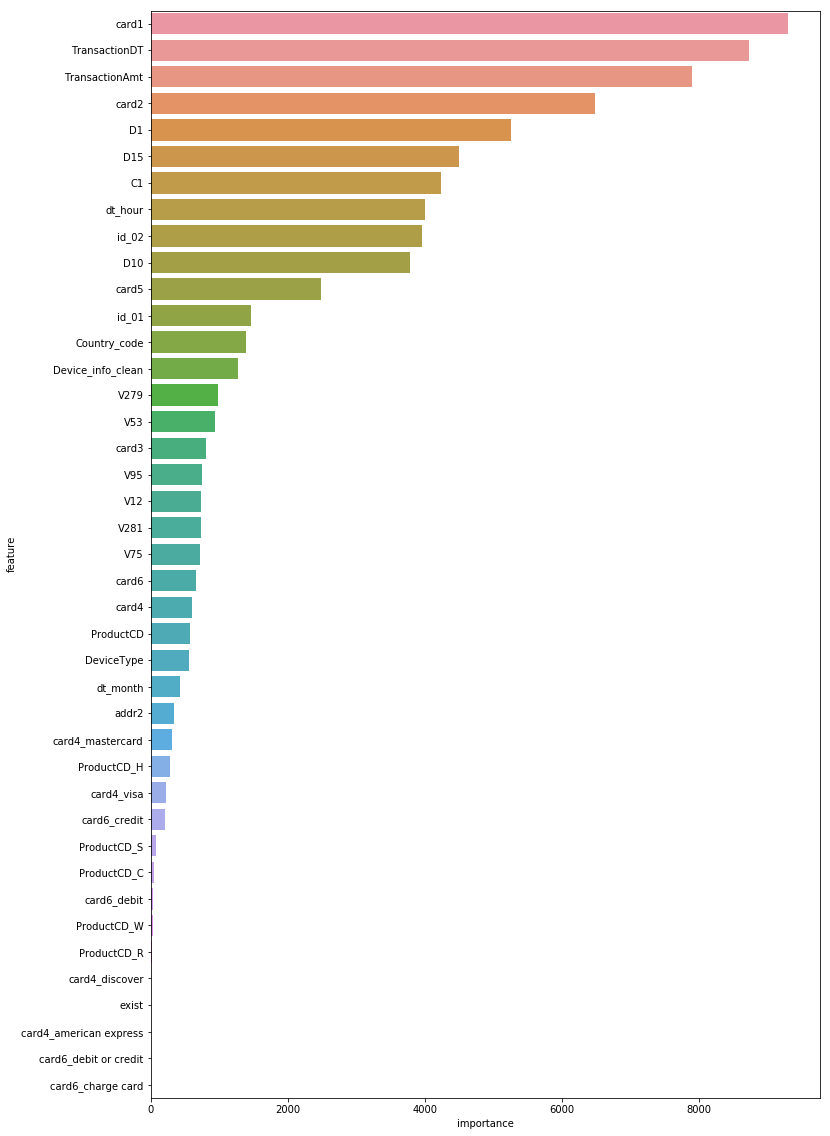

In [0]:
importance_df = pd.DataFrame({
    'feature': features,
    'importance': feature_importance
})

fig = plt.figure(figsize=(12, 20))
sns.barplot(x='importance', y='feature', data=importance_df.sort_values(by='importance', ascending=False)[:50])
plt.show()

In [0]:
sub = pd.read_csv('sample_submission.csv')
sub['isFraud'] = preds
sub.to_csv('submission.csv', index=False)